In [1]:
import pandas as pd
import nltk
from nltk.corpus import wordnet
nltk.download('wordnet')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adammiyauchi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# qa_df = pd.read_csv('image_aug_analysis_cocoqa_val2014.csv').dropna().reset_index(drop=True)
qa_df = pd.read_csv('image_aug_analysis_cocoqa_val2014_final.csv').dropna().reset_index(drop=True)

# qa_df = qa_df[qa_df['type'] == 0]
print('Number Samples: ', len(qa_df))
print(qa_df['type'].value_counts())         # 0 -> object, 1 -> number, 2 -> color, 3 -> location
qa_df.tail(5)

Number Samples:  2299
type
0    1631
2     374
1     153
3     141
Name: count, dtype: int64


/var/folders/w4/q7bv_t1n0sg6qb2mwj26k__h0000gn/T/ipykernel_48396/2350500715.py:2: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  qa_df = pd.read_csv('image_aug_analysis_cocoqa_val2014_final.csv').dropna().reset_index(drop=True)


,img_id,question,answer,type,ib_original,fla_original,ib_blurSm,fla_blurSm,ib_blurMd,fla_blurMd,ib_blurLg,fla_blurLg,ib_chnlDrp,fla_chnlDrp,ib_solar,fla_solar,ib_elastic,fla_elastic
2294,412690,what is rushing to meet the cruise ship,boat,0,boat,icing,boat,icing,boat,icing,boat,icing,boat,icing,boat,icing,boat,icing
2295,171548,what are in the middle of traffic,motorcycles,0,motorcycles,iced tea,motorcycles,iced tea,motorcycles,iced tea,motorcycles,iced tea,motorcycles,iced tea,motorcycles,iced tea,truck,iced tea
2296,459487,what graze in the valley near a small town,sheep,0,cows,"erm, sheep",cows,ute and sheep,cows,"erm, cows",cows,"erm, cows",cows,"erm, sheep",cows,"erm, sheep?",cows,"erm, sheep?"
2297,6473,what topped with the beach scene,cake,0,cake,icing,cake,icing,cake,icing,cake,icing,cake,icing,cake,icing,cake,icing
2298,449031,what is the color of the bus,yellow,2,yellow,umber,yellow,umber,yellow,umber,yellow,umber,orange,iced tea,blue and yellow,umber,yellow,umber yellow


In [3]:
def accuracy_exact_match(pred, target):
    '''
    Checks if the target is a substring of the prediction. Makes pred and target strings lowercase first. 
    '''
    comp = np.array([t.lower() in p.lower() for t, p in zip(target, pred)])
    # comp = [t == p for t, p in zip(target, pred)]
    return comp


def accuracy_synonmy(pred, target):
    '''
    Checks if the target or is a substring of the prediction or a synanym of the prediction. Makes pred adn target strings lowercase first.
    '''
    comp = [any(syn.lower() in p.lower() for syn in get_synonyms(t.lower())) for p, t in zip(pred, target)]
    # comp = np.array([p.lower() in get_synonyms(t) for p, t in zip(pred, target)])
    return comp
    # return comp.sum() / len(comp)


def get_synonyms(word):
    synonyms = [word]
    for syn in wordnet.synsets(word.lower()):
        for lm in syn.lemmas():
            synonyms.append(lm.name().replace('_', ' '))
    # synonyms = ' '.join(synonyms)
    return synonyms

In [4]:
eval = pd.DataFrame()

for c in qa_df.columns[4:]:
    eval[f'{c}_exact_accuracy'] = accuracy_exact_match(qa_df[c], qa_df['answer'])
    eval[f'{c}_synonym_accuracy'] = accuracy_synonmy(qa_df[c], qa_df['answer'])
    eval[f'{c}_exact_accuracy'] = eval[f'{c}_exact_accuracy'].astype(int)
    eval[f'{c}_synonym_accuracy'] = eval[f'{c}_synonym_accuracy'].astype(int)


eval.tail()

,ib_original_exact_accuracy,ib_original_synonym_accuracy,fla_original_exact_accuracy,fla_original_synonym_accuracy,ib_blurSm_exact_accuracy,ib_blurSm_synonym_accuracy,fla_blurSm_exact_accuracy,fla_blurSm_synonym_accuracy,ib_blurMd_exact_accuracy,ib_blurMd_synonym_accuracy,...,fla_chnlDrp_exact_accuracy,fla_chnlDrp_synonym_accuracy,ib_solar_exact_accuracy,ib_solar_synonym_accuracy,fla_solar_exact_accuracy,fla_solar_synonym_accuracy,ib_elastic_exact_accuracy,ib_elastic_synonym_accuracy,fla_elastic_exact_accuracy,fla_elastic_synonym_accuracy
2294,1,1,0,0,1,1,0,0,1,1,...,0,0,1,1,0,0,1,1,0,0
2295,1,1,0,0,1,1,0,0,1,1,...,0,0,1,1,0,0,0,0,0,0
2296,0,0,1,1,0,0,1,1,0,0,...,1,1,0,0,1,1,0,0,1,1
2297,1,1,0,0,1,1,0,0,1,1,...,0,0,1,1,0,0,1,1,0,0
2298,1,1,0,0,1,1,0,0,1,1,...,0,0,1,1,0,0,1,1,1,1


In [5]:
def get_results(question_type=[0, 1, 2, 3]):
    results = eval.iloc[qa_df[qa_df['type'].isin(question_type)].index]
    results = (results.sum() / results.count()).reset_index()
    results[['model', 'aug', 'metric', '_']] = results['index'].str.split('_', expand=True)
    results = results.sort_values(by=['metric', 'model', 'aug'])
    results = results.rename(columns = {0: 'accuracy'})
    return results


In [6]:
# results = (eval.sum() / eval.count()).reset_index()
# results[['model', 'aug', 'metric', '_']] = results['index'].str.split('_', expand=True)
# results = results.sort_values(by=['metric', 'model', 'aug'])
# results = results.rename(columns = {0: 'accuracy'})
# results


In [9]:

def plot_blur_results(results, title):
    # print(len(results))
    # display(results)
    g = sns.barplot(
        data = results[(results['metric'] == 'exact') & (results['aug'].isin(['blurLg', 'blurMd', 'blurSm', 'original']))],
        x = 'aug', y = 'accuracy', hue='model'
    )
    g.set_title(title)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    for container in g.containers:
        g.bar_label(container, fmt='%.4f')
    plt.show()


def plot_elastic_transform_results(results, title):
    g = sns.barplot(
        data = results[(results['metric'] == 'exact') & (results['aug'].isin(['elastic', 'original']))],
        x = 'aug', y = 'accuracy', hue='model'
    )
    g.set_title(title)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    for container in g.containers:
        g.bar_label(container, fmt='%.4f')
    plt.show()

def plot_channel_drop_results(results, title):
    g = sns.barplot(
        data = results[(results['metric'] == 'exact') & (results['aug'].isin(['chnlDrp', 'original']))],
        x = 'aug', y = 'accuracy', hue='model'
    )
    g.set_title(title)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    for container in g.containers:
        g.bar_label(container, fmt='%.4f')
    plt.show()

def plot_solarization_results(results, title):
    g = sns.barplot(
        data = results[(results['metric'] == 'exact') & (results['aug'].isin(['solar', 'original']))],
        x = 'aug', y = 'accuracy', hue='model'
    )
    g.set_title(title)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    for container in g.containers:
        g.bar_label(container, fmt='%.4f')
    plt.show()


### Results - InstructBlip

In [10]:
res = get_results()
res[(res['model'] == 'ib') & (res['metric'] == 'exact')].sort_index()

,index,accuracy,model,aug,metric,_
0,ib_original_exact_accuracy,0.679426,ib,original,exact,accuracy
4,ib_blurSm_exact_accuracy,0.662897,ib,blurSm,exact,accuracy
8,ib_blurMd_exact_accuracy,0.645063,ib,blurMd,exact,accuracy
12,ib_blurLg_exact_accuracy,0.641148,ib,blurLg,exact,accuracy
16,ib_chnlDrp_exact_accuracy,0.625489,ib,chnlDrp,exact,accuracy
20,ib_solar_exact_accuracy,0.620270,ib,solar,exact,accuracy
24,ib_elastic_exact_accuracy,0.671596,ib,elastic,exact,accuracy


### Image Blur Results

In [ ]:
plot_blur_results(get_results(), 'All Question Types - Image Blur')
plot_blur_results(get_results(question_type=[0]), 'Object Questions - Image Blur')
plot_blur_results(get_results(question_type=[1]), 'Number Questions - Image Blur')
plot_blur_results(get_results(question_type=[2]), 'Color Questions - Image Blur')
plot_blur_results(get_results(question_type=[3]), 'Location Questions - Image Blur')


### Elastic Transform Results

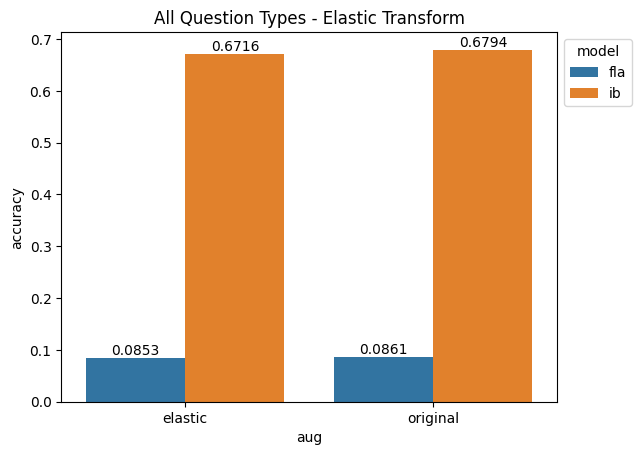

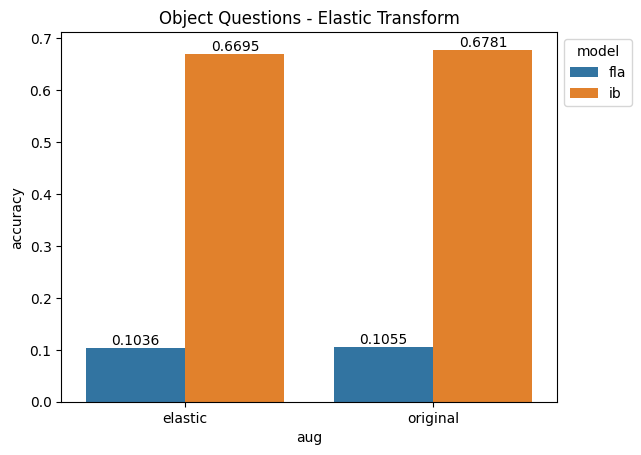

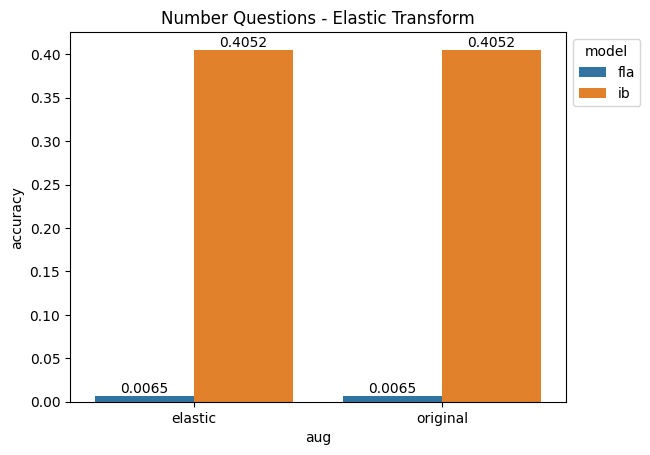

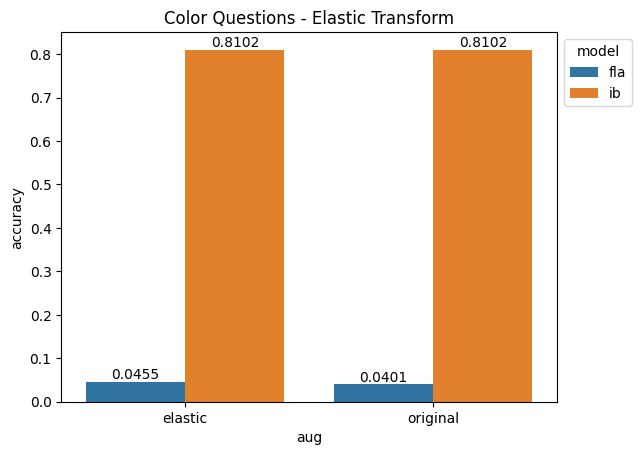

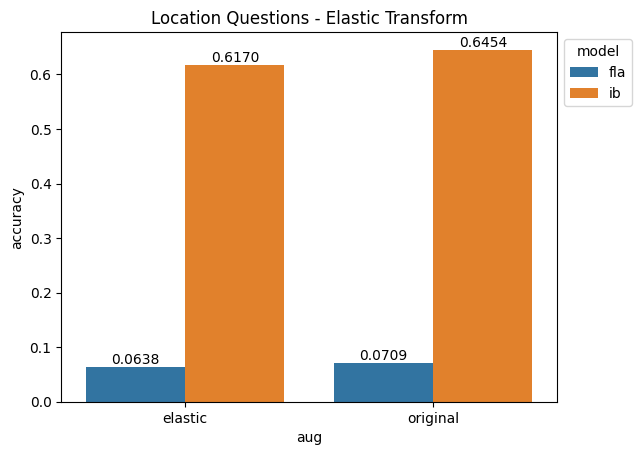

In [11]:
plot_elastic_transform_results(get_results(), 'All Question Types - Elastic Transform')
plot_elastic_transform_results(get_results(question_type=[0]), 'Object Questions - Elastic Transform')
plot_elastic_transform_results(get_results(question_type=[1]), 'Number Questions - Elastic Transform')
plot_elastic_transform_results(get_results(question_type=[2]), 'Color Questions - Elastic Transform')
plot_elastic_transform_results(get_results(question_type=[3]), 'Location Questions - Elastic Transform')

### Channel Dropout Results

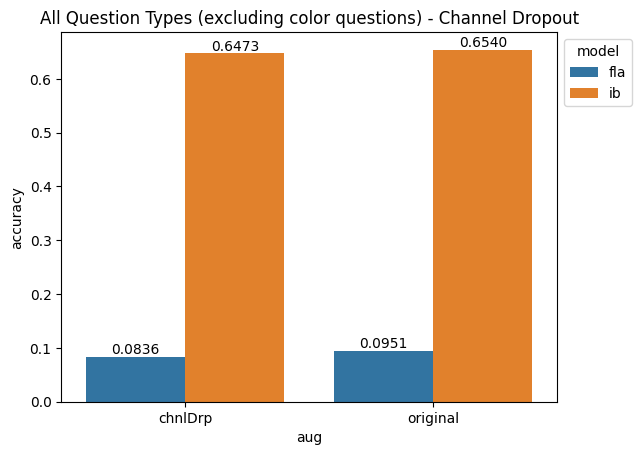

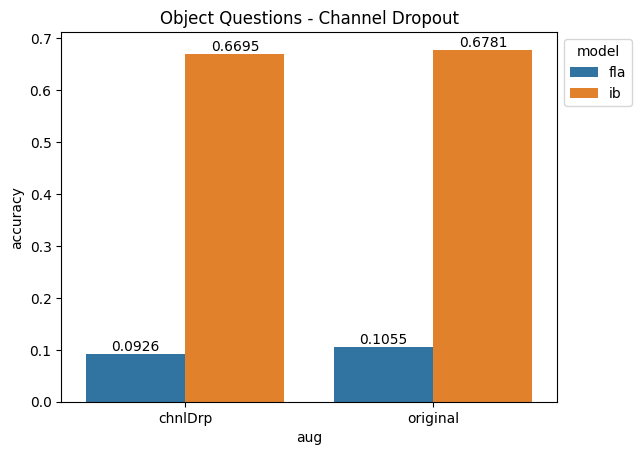

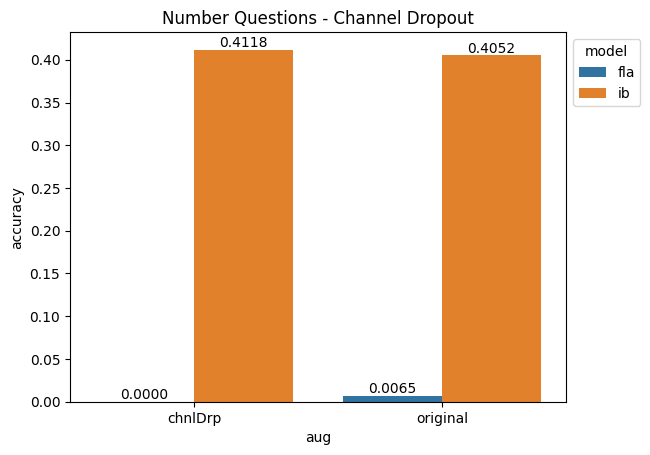

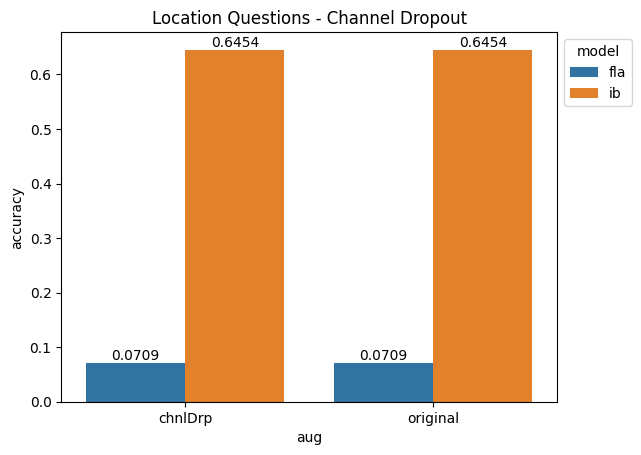

In [12]:
plot_channel_drop_results(get_results(question_type=[0,1,3]), 'All Question Types (excluding color questions) - Channel Dropout')
plot_channel_drop_results(get_results(question_type=[0]), 'Object Questions - Channel Dropout')
plot_channel_drop_results(get_results(question_type=[1]), 'Number Questions - Channel Dropout')
plot_channel_drop_results(get_results(question_type=[3]), 'Location Questions - Channel Dropout')

### Solarization Results

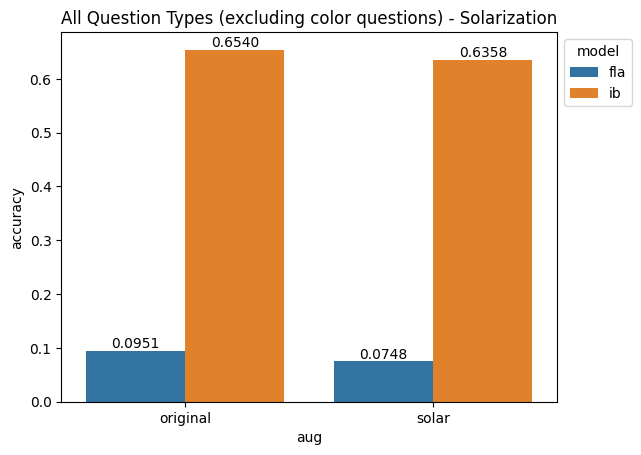

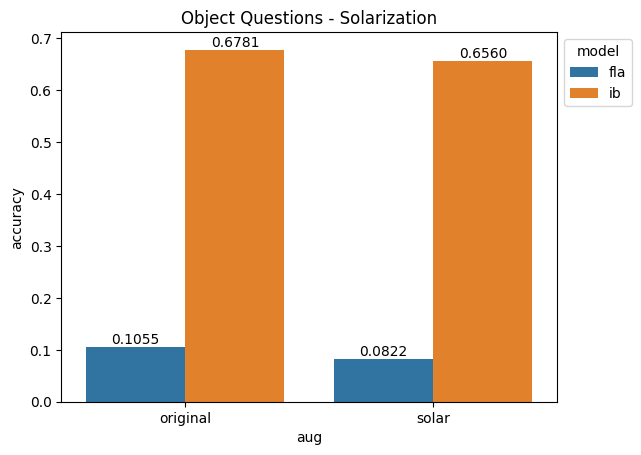

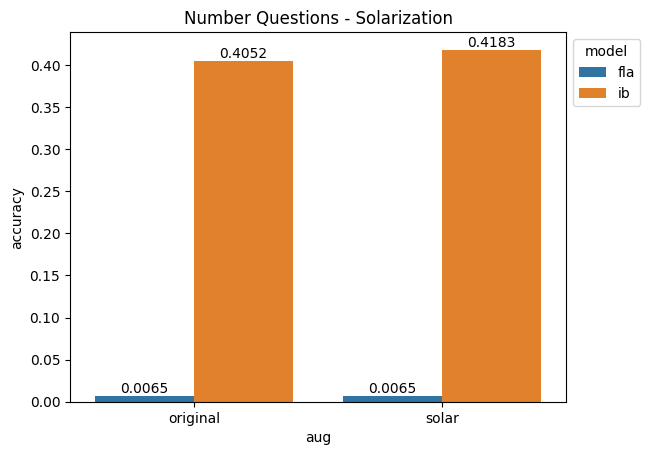

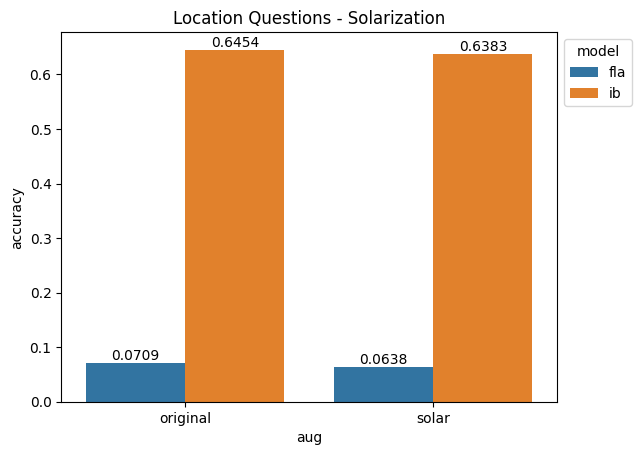

In [13]:
plot_solarization_results(get_results(question_type=[0,1,3]), 'All Question Types (excluding color questions) - Solarization')
plot_solarization_results(get_results(question_type=[0]), 'Object Questions - Solarization')
plot_solarization_results(get_results(question_type=[1]), 'Number Questions - Solarization')
plot_solarization_results(get_results(question_type=[3]), 'Location Questions - Solarization')